# Training a deep Boltzmann machine (DBM)
### Application to the MNIST dataset

YJ Choe (yojoongc@andrew.cmu.edu)

#### Setup

In [1]:
%cd ../code/NN/

/Users/YJ/Dropbox/Code/deep_learning/hw3/code/NN


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dbm import DBM
from rbm import RBM
from nn.utils import load_data, binarize_data
from nn.visualization import print_image

#### Load and binarize data

In [3]:
X_train, X_valid, X_test, y_train, y_valid, y_test = \
    load_data('../../data/digitstrain.txt',
              '../../data/digitsvalid.txt',
              '../../data/digitstest.txt')

In [4]:
X_train.shape, y_train.shape

((3000, 784), (3000, 10))

In [5]:
X_train = binarize_data(X_train)
X_valid = binarize_data(X_valid)
X_test  = binarize_data(X_test)

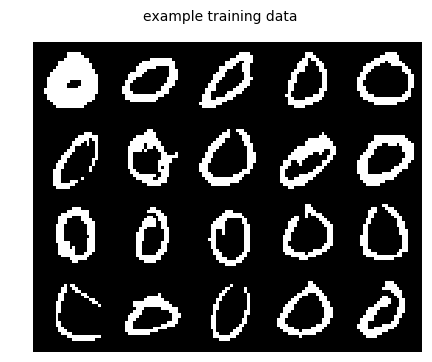

In [6]:
print_image(X_train[:20, :], output_shape=(4, 5), 
            title='example training data')
None # should be binarized

## (a) Basic generalization

### Model initialization

Weights $W \in \mathbb{R}^{n \times m}$ are initialized from a $\mathrm{Unif}(-u, u)$ where $u = \frac{\sqrt{6}}{\sqrt{n+m}}$, as described in the lecture. Bias terms are initialized to zero.

In [7]:
dbm = DBM(n_visible=784, n_hidden1=100, n_hidden2=100,
          n_chains=100, n_vi_steps=10, n_gibbs_steps=1,
          learning_rate=0.005, early_stopping=True,
          seed=21)

In [8]:
dbm.W1.shape, dbm.W2.shape, dbm.b1.shape, dbm.b2.shape, dbm.c.shape

((100, 784), (100, 100), (100, 1), (100, 1), (784, 1))

### Training

Cross-entropy error is computed as the average over all training (or validation) dataset and summed over all dimensions. 

_Note that we use a very small batch size, which (as a side effect) leads to a longer CD Gibbs chain._

dbm = DBM.load('../../models/dbm-{}-{}-{}-{}-{}-{}-{}-{}.pkl'.format(
               dbm.n_hidden1, dbm.n_hidden2, dbm.n_chains, 
               dbm.n_vi_steps, dbm.n_gibbs_steps, 
               dbm.learning_rate.const, dbm.early_stopping,
               40))

In [9]:
n_epoch = 40
dbm.train(X_train, X_valid,
          batch_size=2, n_epoch=n_epoch, batch_seed=24, 
          verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         178.03008         |         179.13796         |
|    2  |         158.03986         |         159.60002         |
|    3  |         143.60260         |         145.91276         |
|    4  |         142.73337         |         146.04209         |
|    5  |         134.53733         |         137.69509         |
|    6  |         131.77762         |         135.85492         |
|    7  |         131.79840         |         135.75263         |
|    8  |         123.61948         |         127.84872         |
|    9  |         123.31960         |         128.20992         |
|   10  |         122.13681         |         127.24702         |
|   11  | 

In [10]:
dbm.save('../../models/dbm-{}-{}-{}-{}-{}-{}-{}-{}.pkl'.format(
         dbm.n_hidden1, dbm.n_hidden2, dbm.n_chains, 
         dbm.n_vi_steps, dbm.n_gibbs_steps, 
         dbm.learning_rate.const, dbm.early_stopping,
         dbm.epoch))
None

Next, we show the plots of training and validation errors. The validation error starts to go up at around 130 epochs.

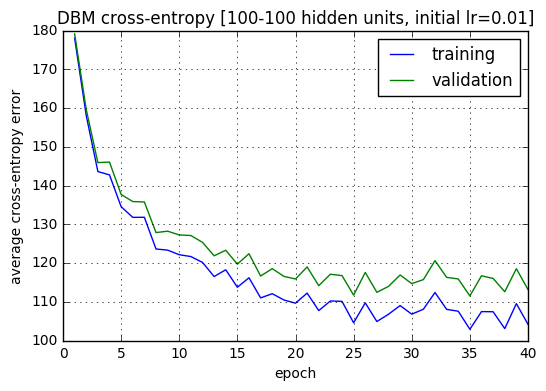

In [11]:
plt.grid()
plt.plot(*zip(*dbm.training_error), label='training')
plt.plot(*zip(*dbm.validation_error), label='validation')
plt.title('DBM cross-entropy [100-100 hidden units, initial lr={:.2f}]'.format(dbm.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

As requested in the homework, we now train 5 more neural networks with different initializations.

In [14]:
dbms = [dbm]
for i in range(1, 6):
    dbm0 = DBM(n_visible=784, n_hidden1=100, n_hidden2=100,
               n_chains=100, n_vi_steps=10, n_gibbs_steps=1,
               learning_rate=0.005, early_stopping=True,
               seed=44*i)
    dbm0.train(X_train, X_valid,
               batch_size=2, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    dbms.append(dbm0)
    print('DBM #{:d} training complete ({:d} epochs)'.format(i, n_epoch))
    print('Final training error: {:.5f}'.format(dbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(dbm0.validation_error[-1][1]))

======Early stopping: validation error increase at epoch  40=====
DBM #1 training complete (40 epochs)
Final training error: 158.15997
Final validation error: 160.17921
======Early stopping: validation error increase at epoch  40=====
DBM #2 training complete (40 epochs)
Final training error: 108.45526
Final validation error: 117.40731
======Early stopping: validation error increase at epoch  40=====
DBM #3 training complete (40 epochs)
Final training error: 156.45412
Final validation error: 158.77695
======Early stopping: validation error increase at epoch  40=====
DBM #4 training complete (40 epochs)
Final training error: 173.30989
Final validation error: 176.75925
======Early stopping: validation error increase at epoch  40=====
DBM #5 training complete (40 epochs)
Final training error: 174.57355
Final validation error: 176.47532


It appears that the validation cross-entropy errors are roughly the same across different initializations. We proceed with the first model.

### Visualizing parameters

First, we take the first hidden layer units and plot them as images. As shown below, the filters seem to capture digit-like shapes, as we saw with 2-layer feedforward neural networks. 

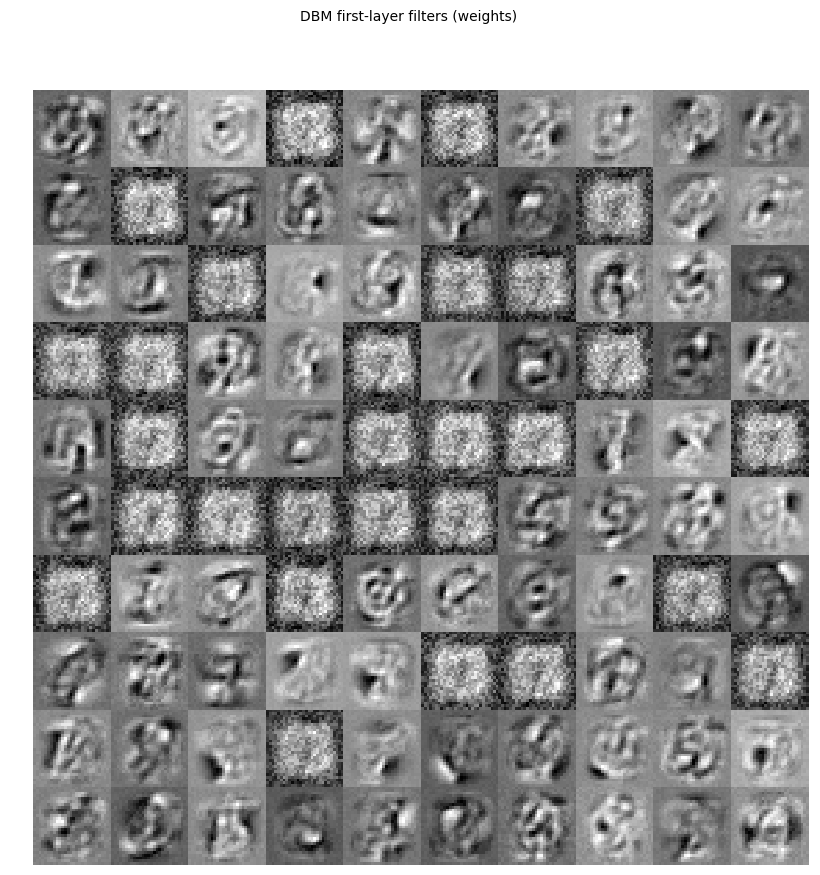

In [12]:
assert dbm.W1.shape[0] >= 100
print_image(dbm.W1[:100,:], output_shape=(10, 10),
            title='DBM first-layer filters (weights)')
None

Next, we display the visible and hidden units from the persistent chain.

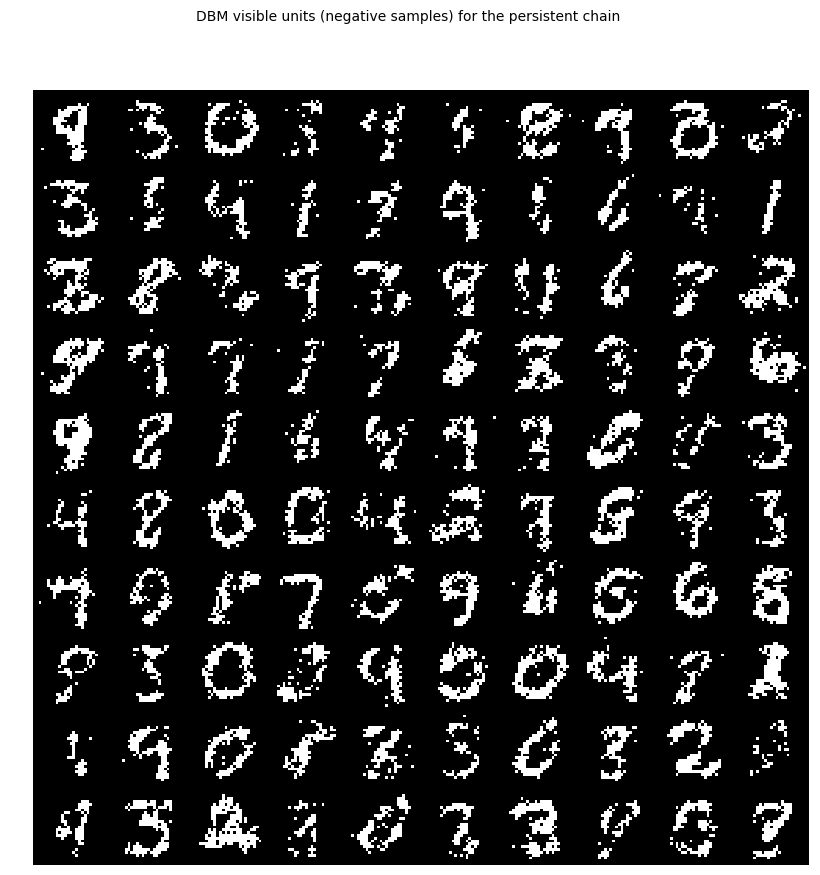

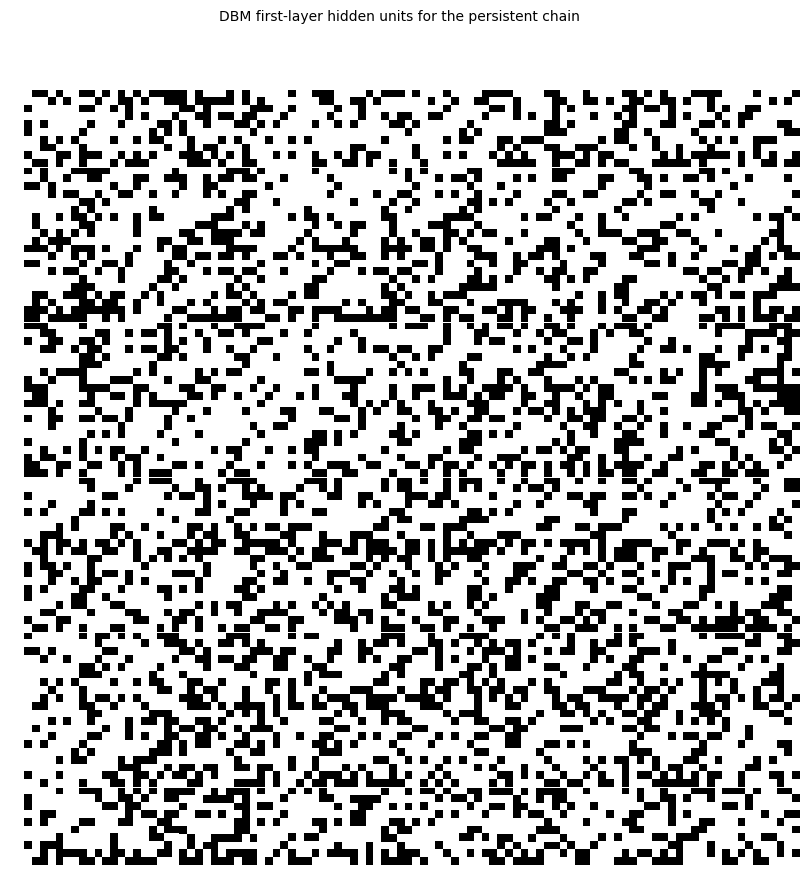

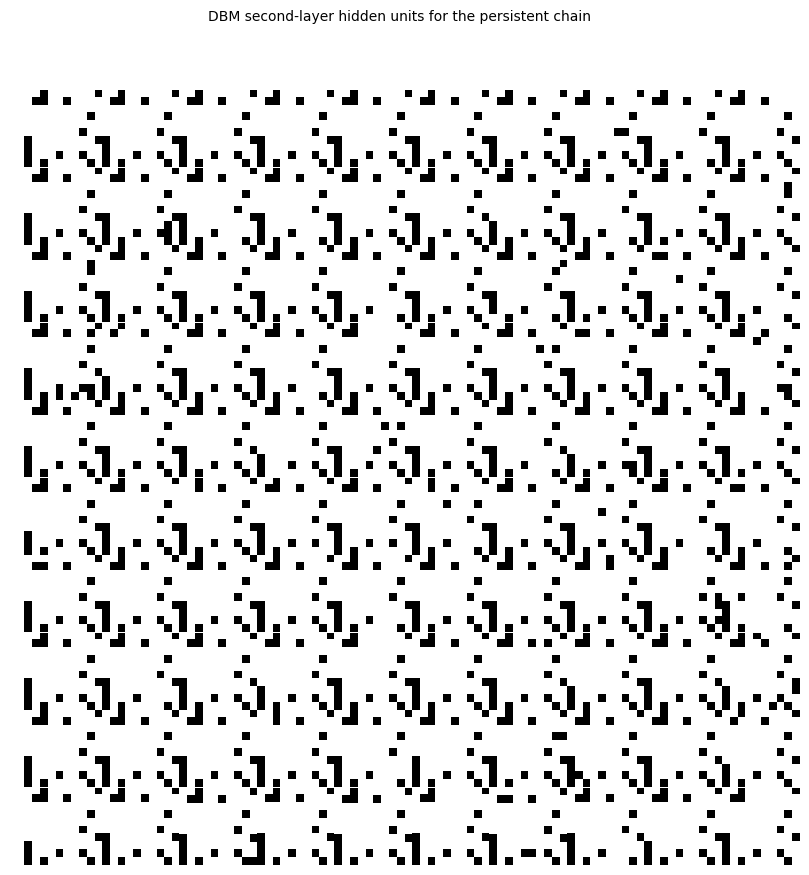

In [15]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 25, replace=False)

print_image(dbm.X_chain, output_shape=(10, 10),
            title='DBM visible units (negative samples) for the persistent chain')
print_image(dbm.H1_chain, output_shape=(10, 10),
            title='DBM first-layer hidden units for the persistent chain')
print_image(dbm.H2_chain, output_shape=(10, 10),
            title='DBM second-layer hidden units for the persistent chain')
None

The visible units are digit-like, which is a good sign. On the other hand, the second set of hidden units are nearly identical, which draws some concern.

## (b) Samples from the DBM model

Here we take 100 samples of new images from the trained model by starting from 100 random visible units and running 1000 steps of Gibbs sampling for each of the 100 random inputs. 

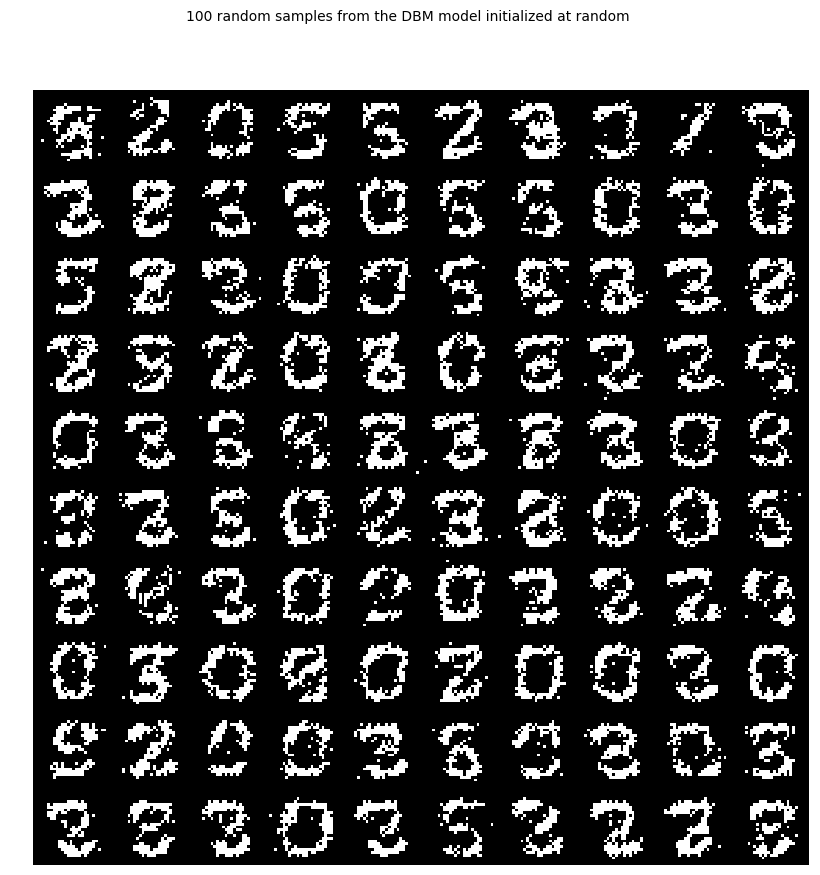

In [13]:
rng = np.random.RandomState(100)
dbm.n_gibbs_steps = 1000
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
X_new    = dbm.generate_negative_sample(X_random)
dbm.n_gibbs_steps = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the DBM model initialized at random')
None

We can observe a lot of digit-like shapes with small amount of noise. There are a bunch of zeros and eights, as well as things "in between" -- twos, threes, fives, sixes and sevens.

## (c) Comparisons to a single-layer RBM model

We now train a single-layer RBM using persistent contrastive divergence and compare the samples. Note that we use a smaller learning rate due to the decrease in capacity (i.e. number of parameters).

In [16]:
n_epoch = 50
rbm = RBM(n_visible=784, n_hidden=100, k=1, persistent=True,
          learning_rate=0.002, early_stopping=True,
          seed=22)
rbm.train(X_train, X_valid,
          batch_size=2, n_epoch=n_epoch, batch_seed=24, 
          verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         194.13930         |         194.95457         |
|    2  |         163.99100         |         165.07667         |
|    3  |         152.00091         |         153.50839         |
|    4  |         143.78545         |         145.76843         |
|    5  |         137.36299         |         139.25935         |
|    6  |         131.46316         |         133.75534         |
|    7  |         128.14968         |         130.61002         |
|    8  |         123.47372         |         125.82861         |
|    9  |         119.89939         |         122.51046         |
|   10  |         117.86807         |         120.73952         |
|   11  | 

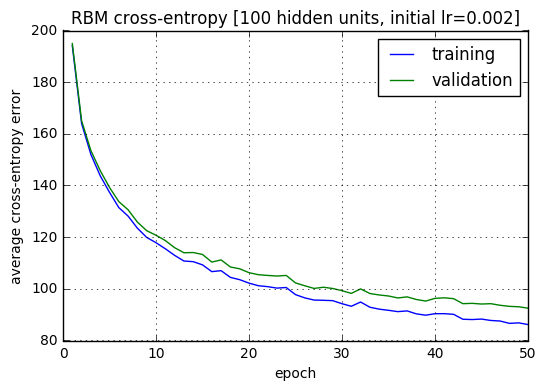

In [17]:
plt.grid()
plt.plot(*zip(*rbm.training_error), label='training')
plt.plot(*zip(*rbm.validation_error), label='validation')
plt.title('RBM cross-entropy [100 hidden units, initial lr={:.3f}]'.format(rbm.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

We analogously generate 100 samples from random initialization, using 1000 Gibbs steps:

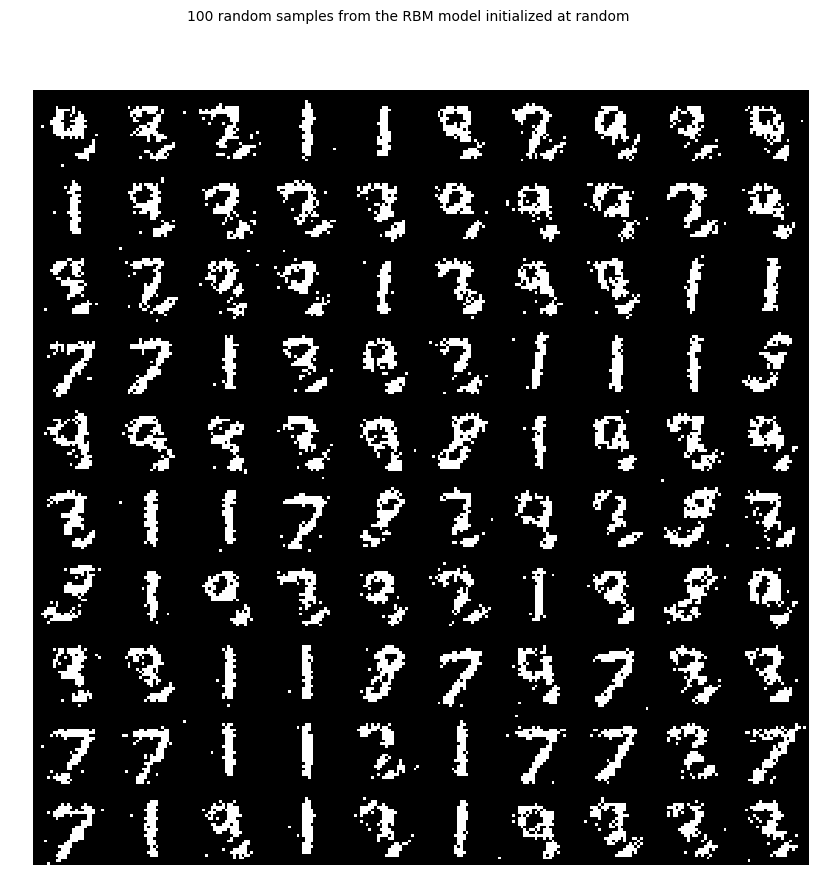

In [18]:
rng      = np.random.RandomState(100)
rbm.k    = 1000
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
X_new    = rbm.generate_negative_sample(X_random)
rbm.k    = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the RBM model initialized at random')
None

Despite using more epochs, the single-layer RBM seems to give digits of similar quality. They are digit-like but not perfect.

## (d) Number of hidden units

We now validate over the number of hidden units. 

In [19]:
dbms = []
n_hidden_units = [200, 400]
n_epoch = 50
for i, n_hidden in enumerate(n_hidden_units):
    dbm0 = DBM(n_visible=784, n_hidden1=n_hidden, n_hidden2=n_hidden,
               n_chains=100, n_vi_steps=10, n_gibbs_steps=1,
               learning_rate=0.01, early_stopping=True,
               seed=7)
    dbm0.train(X_train, X_valid,
               batch_size=2, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    dbm0.save('../../models/dbm-{}-{}-{}-{}.pkl'.format(
              dbm0.n_hidden1, dbm0.n_hidden2, 
              dbm0.learning_rate.const, dbm0.epoch))
    dbms.append(dbm0)
    print('DBM #{:d} with {:d} hidden units training complete ({:d} epochs)'.format(i, n_hidden, n_epoch))
    print('Final training error: {:.5f}'.format(dbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(dbm0.validation_error[-1][1]))

======Early stopping: validation error increase at epoch  40=====
DBM #0 with 200 hidden units training complete (50 epochs)
Final training error: 112.14609
Final validation error: 129.28309
======Early stopping: validation error increase at epoch  40=====
DBM #1 with 400 hidden units training complete (50 epochs)
Final training error: 139.95485
Final validation error: 161.47266


It appears that using more units directly lead to smaller cross-entropy error, at least within 40 epochs. One may want to worry about overfitting here. We generate 1000-step Gibbs samples from the 200-unit and 400-unit DBMs below (respectively):

In [20]:
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))

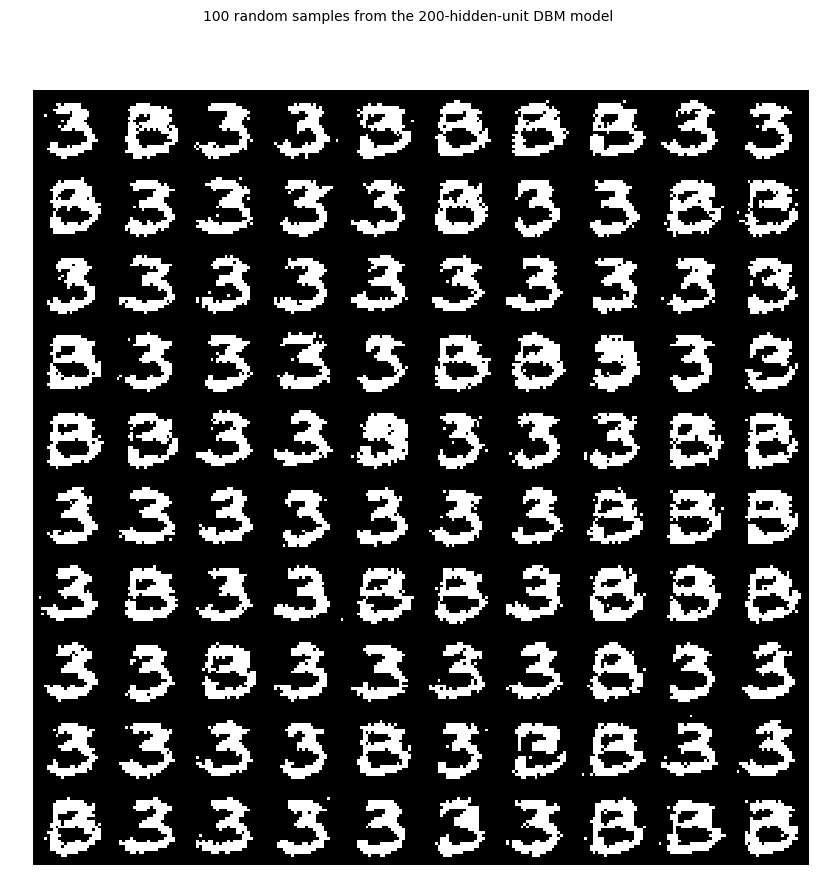

In [21]:
dbm200 = dbms[0]
dbm200.n_gibbs_steps = 1000
X_new = dbm200.generate_negative_sample(X_random)
dbm200.n_gibbs_steps = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the 200-hidden-unit DBM model')
None

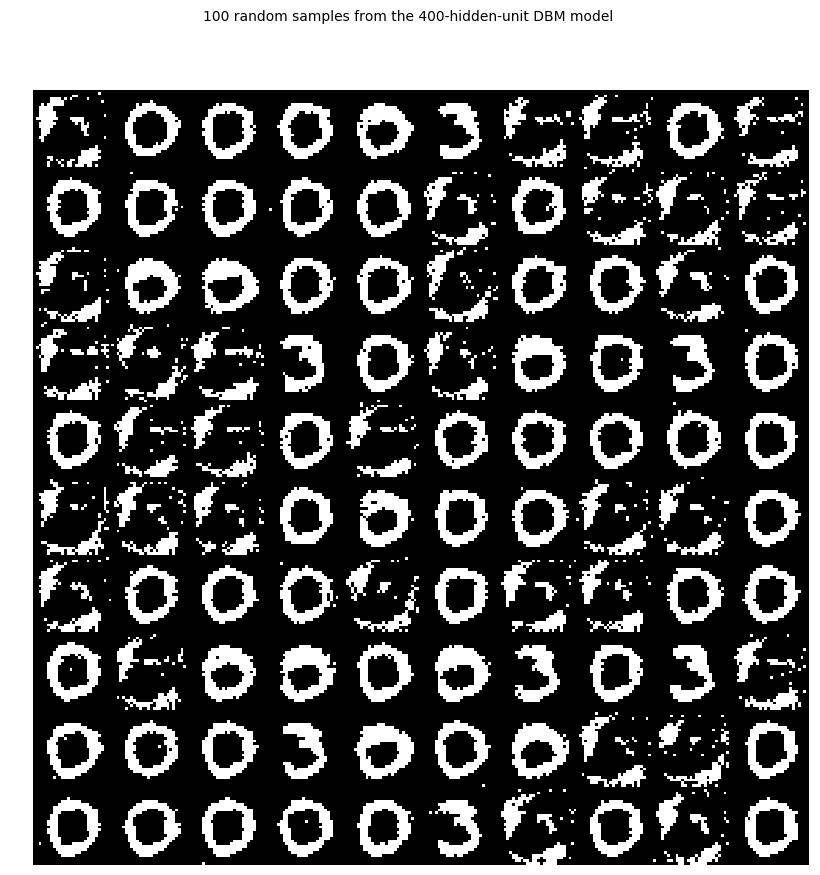

In [22]:
dbm400 = dbms[1]
dbm400.n_gibbs_steps = 1000
X_new = dbm400.generate_negative_sample(X_random)
dbm400.n_gibbs_steps = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the 400-hidden-unit DBM model')
None

Given bigger capacities, we need more training time and finer validation of the hyperparameters in order to obtain better digits. This will be possible with more training.